In [1]:
# HOME
import os
import scipy
# get the code
import sys
sys.path.append('../scripts')
from codeCNV.plot import plot_snp, plot_genomic
from codeCNV.rollingCNV import apply_rolling_coverage
from script_utils import show_output

home = '/Users/mahtin'
# home = '/Users/martinscience'
# standard paths
testdata = os.path.join(home,"Dropbox/Icke/Work/somVar/testdata")
static_path = os.path.join(home, "Dropbox/Icke/Work/static")
cluster_path = os.path.join(home, "mount")
tooldata = os.path.join(home, "Dropbox/Icke/Work/somVar/tooldata")

# load the config
# edit config directly in yaml file
import yaml
config_file = '../config/config_devel.yaml'
def get_config(config_file, param):
        with open(config_file) as file:
        # The FullLoader parameter handles the conversion from YAML
        # scalar values to Python the dictionary format
            config = yaml.load(file, Loader=yaml.FullLoader)['CNV'][param]
        return config
config = get_config(config_file, 'combine')


cnvdata = os.path.join(tooldata, "myCNVdata")
output_path = os.path.join(cnvdata, "output")

# the path to the input data
cnv_path = os.path.join(cnvdata, "cnv")
cnvPON_path = cnv_path = os.path.join(cnvdata, "chromCov")
cnv_path = os.path.join(cluster_path, "scratch/develop/PONcoverage/cnv")
cnvPON_path = os.path.join(cluster_path, "scratch/develop/PONcoverage/chromCov")

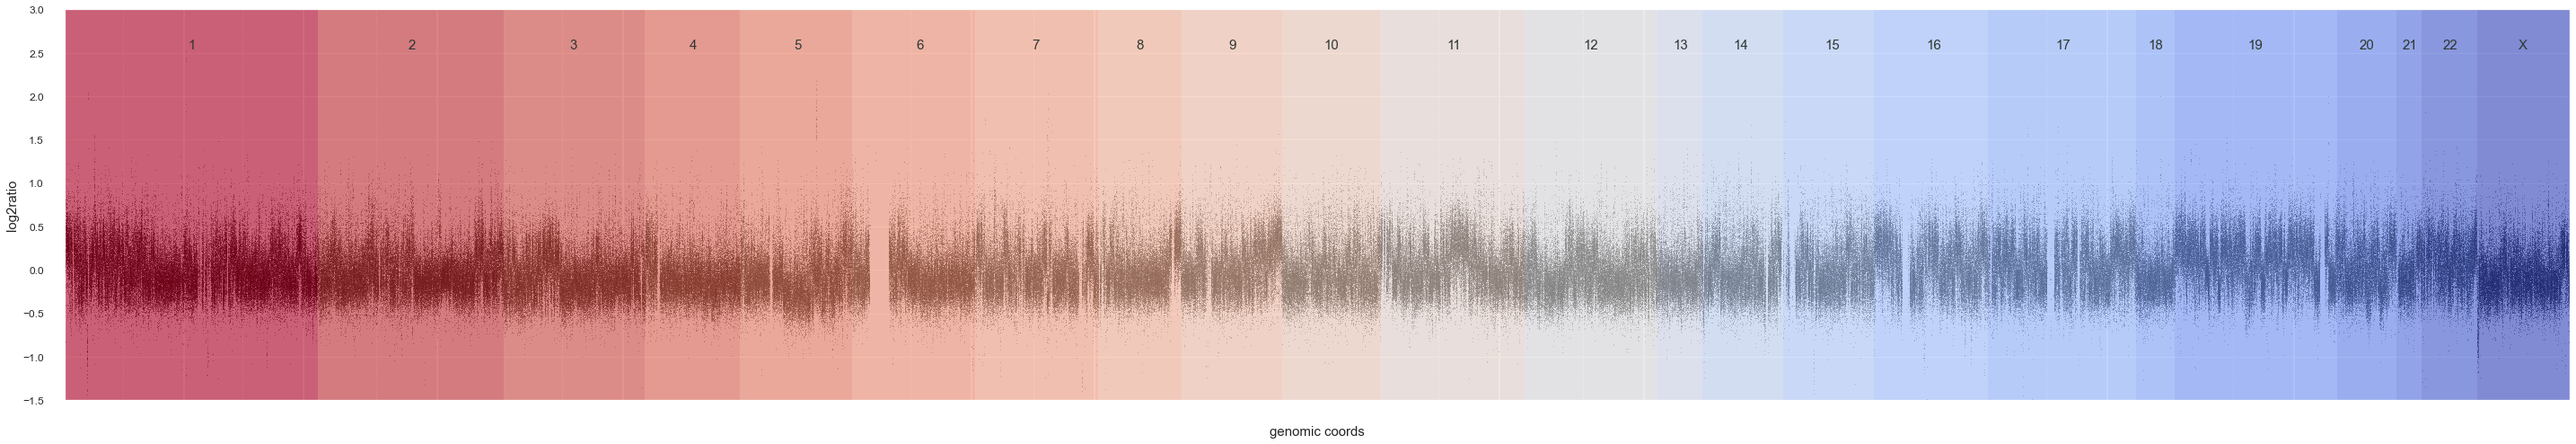

In [2]:
sample = "02_B"
cov_df = pd.read_csv(os.path.join(output_path, f'CNV/{sample}.cov'), sep='\t').query('log2ratio == log2ratio')
fig_params = dict(
    figsize=(50,8),
    colormap='coolwarm_r',
    color_chroms=True,
    ylim=(-1.5,3)
)
log2 = dict(
        title='log2ratio',
        plot_type='scatter',   # ['line', 'scatter']
        data='log2ratio',
        plot_args=dict(
            linewidth=0.3,
            color='black',
            s=0.2,
            alpha=.7
        ))

fig, ax, _, chrom_df = plot_genomic(cov_df.query('Coverage > 50 and PONmeanCov > 50 and PONstd < 100'), plots=[log2], chroms='all', region='', **fig_params)

## run the code
+ also get the snp_df for transferring FullExonPos

In [ ]:
samples = ['02', '01', '03']

for sample in [f"{s}_{t}" for s in samples for t in ['A', 'B']]:
    print(f'Running sample {sample}')
    snp_df = pd.read_csv(os.path.join(output_path, f'CNV/{sample}.snp'), sep='\t')
    cov_df = pd.read_csv(os.path.join(output_path, f'CNV/{sample}.cov'), sep='\t').query('log2ratio == log2ratio')
    snpcov_df, rolling_cov_df = apply_rolling_coverage(snp_df, cov_df, config)
    snpcov_df.to_csv(os.path.join(output_path, f'tmp/{sample}.snpcov.gz'), sep='\t', index=False, compression="gzip")
    rolling_cov_df.to_csv(os.path.join(output_path, f'CNV/{sample}.roll.cov.gz'), sep='\t', index=False, compression="gzip")

Computing covCenter log-likelihood.
Computing log-likelihood of log2ratio belonging to center gaussian [mean:-0.104, sigma:0.256]
Performing rolling coverage.
Normalizing covLLH sum
Identifying CNV blocks.


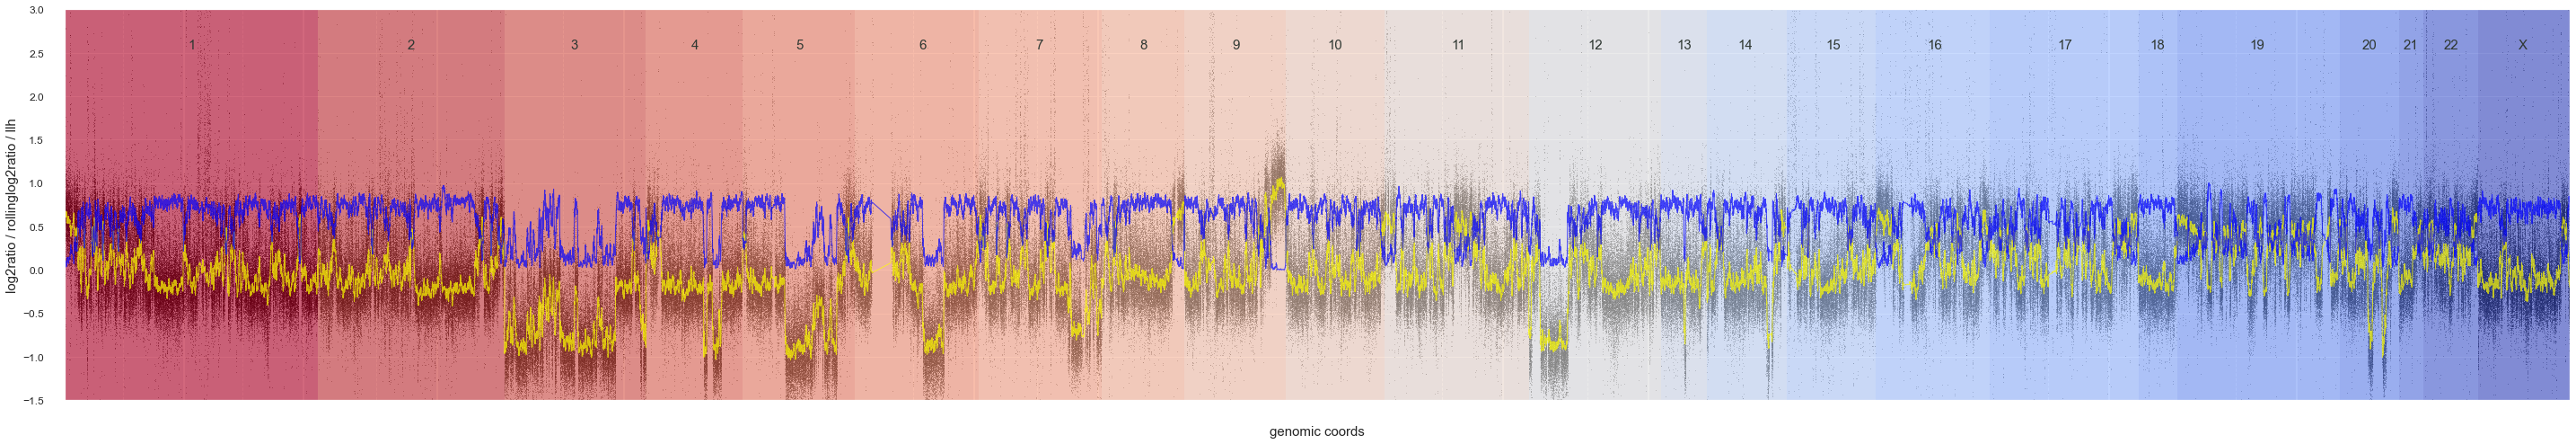

In [3]:
sample = "02_A"
cov_df = pd.read_csv(os.path.join(output_path, f'CNV/{sample}.cov'), sep='\t').query('log2ratio == log2ratio')
snp_df = pd.read_csv(os.path.join(output_path, f'CNV/{sample}.snp'), sep='\t')
snpcov_df, rolling_cov_df = apply_rolling_coverage(snp_df, cov_df, config)

log2mean = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

llh = dict(
        title='llh',
        plot_type='line',   # ['line', 'scatter']
        data='covLLHsum',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

llhdiff = dict(
        title='llh',
        plot_type='line',   # ['line', 'scatter']
        data='covLLHsumDiff',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

log2diff = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomeanDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        ))

log2L = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomeanL',
        plot_args=dict(
            linewidth=1,
            color='white',
            alpha=.7
        ))

log2R = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomeanR',
        plot_args=dict(
            linewidth=1,
            color='black',
            alpha=.7
        ))

chroms = ['chr3', 'chr4', 'chr5', 'chr6', 'chr8', 'chr9', 'chr20']

_, _, _, _ = plot_genomic(rolling_cov_df, plots=[log2,log2mean, llh], chroms='all', region='', **fig_params)

In [ ]:
_, _, _, _ = plot_genomic(rolling_cov_df, plots=[log2,llhdiff, llh], chroms=chroms, region='chr5', **fig_params)

In [ ]:
_, _, _, _ = plot_genomic(rolling_cov_df.query('covCentercore > 0'), plots=[log2,llhdiff, llh], chroms=chroms, region='', **fig_params)

In [ ]:
_, _, _, _ = plot_genomic(rolling_cov_df.query('covCNVcore > 0'), plots=[log2,llhdiff, llh], chroms=chroms, region='', **fig_params)

## Step by step

### assumption: log2ratio is normal-distributed around mean value:
+ with sigma = .2 one can approximate the center masses
+ log-likelihood should be far below average at CNV areas

In [ ]:
import numpy.random as rnd
import matplotlib.pyplot as plt
df = cov_df.copy()
sigma = df.query('-0.5 < log2ratio < .5')['log2ratio'].std()* 1

# get the mean of the center band
mean = df.query('-0.5 < log2ratio < .5')['log2ratio'].mean()
print("mean = ", mean)
print("sigma = ", sigma)
def llh(data, mean, sigma):
    s = np.sqrt(2 * np.pi) * sigma
    return np.exp((data - mean)**2 / (-2*(sigma**2))) / s


r = np.linspace(-2,2,10000)

fig1, ax = plt.subplots(figsize=(10,4))
_ = ax.scatter(r, llh(r, mean, sigma), s=.5, alpha=0.5);
_ = ax.scatter(df['log2ratio'], rnd.random(len(df.index))*4, s=.01, alpha=.1)
_ = ax.set_xlim(-1.5,2)

## compute the llh for center mass for entire sample
+ get the global mean
+ compute loglikelihood
+ rolling sum for chromosome

### custom function for llh computation
+ parameters sigma factor and mean range are taken from config

In [ ]:
def llh(data, mean, sigma):
    s = np.sqrt(2 * np.pi) * sigma
    return np.exp((data - mean)**2 / (-2*(sigma**2))) / s

def compute_coverage_llh(df, config):
    '''
    computes the local log-likelihood of belonging to the center gaussian
    '''
    
    # get config params
    params = config['cov']['LLH']
    
    min_log2ratio, max_log2ratio = params['center_range']
    # get the sigma and mean of the center band log2ratio
    center_logs = df.query('@min_log2ratio < log2ratio < @max_log2ratio')['log2ratio']
    sigma = center_logs.std() * params['sigma_factor']
    mean = center_logs.mean()
    print(f"Computing log-likelihood of log2ratio belonging to center gaussian [mean:{round(mean, 3)}, sigma:{round(sigma,3)}]")
    df.loc[:, 'covLLH'] = llh(df['log2ratio'], mean, sigma)
    
    return df

In [ ]:
# compute llh
df = compute_coverage_llh(df, config)

## rolling window for log2ratio and llh
#### compute the mean for log2ratio
+ this is all done on chromosome-basis
+ the rolling should be performed on coverage data filtered for:
    * minimal coverage
    * minimal coverage in PON samples
    * maximal std of PON coverage

### test rolling_coverage

In [ ]:
def interpolate(df, data_col, ref_col='FullExonPos', expand_limit=20):
    '''
    interpolates missing values in data_col using linear interpolation based on ref_col
    '''
    cols = list(df.columns)
    # set FullExonPos as index for the interpolation method to work on proper intervals
    df = df.reset_index(drop=False).set_index(ref_col, drop=False)
    df.loc[:,data_col] = df[data_col].interpolate(method='values', limit=expand_limit, limit_direction='both')
    return df.set_index('index')[cols]


def normalize_df(df, col):
    '''
    normalize a column of a df
    '''
    _min = df[col].min()
    _max = df[col].max()
    df.loc[:, col] = (df[col] - _min) / (_max - _min)
    return df


def one_col_rolling(df, df_filter, col, aggr, window_size=200, expand_limit=20, normalize=False, debug=False, diff_exp=2, ddof=0):
    '''
    performs rolling computation of <agg> on data column <col> with given window size
    the aggregation can be a:
        - callable taking df[col] as argument and returning a scalar
            column name will be taken from function name (stripping underscores)
        - string expression understood by the agg-function of the pandas.groupby API
            column name will be composed of col + aggr
    computation is performed on a left and right rolling window
    missing margins are filled by the counterpart window function
    a diff column is included ()
    '''

    org_cols = list(df.columns)
    # rolling left
    # check if aggr is a function
    if callable(aggr):
        if debug:
            show_output(f'Aggregating custom function {aggr.__name__}')
        df.loc[:, 'L'] = df_filter[col].rolling(window_size).apply(aggr)
        # pass the function name for ensuing column naming
        col_name = aggr.__name__.replace('_', '')
    else:
        # get the right computation by passing aggr to .agg()
        # only this allows passing methods as string
        df.loc[:, 'L'] = df_filter[col].rolling(window_size).agg(aggr, ddof=ddof)
        col_name = col + aggr
        
    # rolling right by shifting the L column
    df.loc[:, 'R'] = df.shift(-window_size + 1)['L']

    diff_name = col_name + "Diff"
    new_cols = org_cols + [col_name, diff_name]
    if debug:
        new_cols += [f'{col_name}L', f'{col_name}R']
    # skips interpolation if value == 0
    if interpolate:
        # interpolate missing values
        for c in ['L', 'R']:
            df = interpolate(df, c, expand_limit=expand_limit)
    # fill the margins
    L_margin = df['L'].first_valid_index()
    df.loc[:L_margin, 'L'] = df['R']
    R_margin = df['R'].last_valid_index() + 1
    df.loc[R_margin:, 'R'] = df['L']

    # get the Diff
    df.loc[:, diff_name] = np.abs(df['R'] - df['L'])
    # normalize to max
    df.loc[:, diff_name] = df[diff_name] / df[diff_name].max()
    # here, contribution of L and R is controlled by diff value
    df.loc[:, col_name] = df['R'] * \
        df[diff_name] + df['L'] * (1 - df[diff_name])
    
    if normalize:
        df = normalize_df(df, col_name)
        if debug:
            for c in ['L', 'R']:
                df = normalize(df, c)
    
    # square the diff
    df.loc[:, diff_name] = df[diff_name] ** diff_exp

    if debug:
        # specify col names of L and R
        df = df.rename(columns=dict(L=f'{col_name}L', R=f'{col_name}R'))

    # reduce to the right columns
    return df[new_cols]


def rolling_data(df, filter_df, expand=0.25, ddof=0, debug=False, data_params={}):
    '''
    cycles through the data params (rolling_data object from config dict)
    and performs rolling computations for these params
    '''
    # now do global normalization for sum aggregations:
    # cycle through rolling_data
    for data_col in data_params.keys():
        for agg in data_params[data_col].keys():
            # cycle through the chroms
            chrom_dfs = []
            for chrom in df['Chr'].unique():
                # get the chrom_dfs
                chrom_df = df.query('Chr == @chrom').sort_values('FullExonPos')
                filter_chrom_df = filter_df.query('Chr == @chrom').sort_values('FullExonPos')
                window_size = data_params[data_col][agg]
                expand_limit = int(expand * window_size)
                # show_output(f"Computing rolling window for {agg} of {data_col} with window size {window_size} on {chrom}")
                chrom_df = one_col_rolling(chrom_df, filter_chrom_df, data_col, agg, window_size=window_size,
                                           expand_limit=expand_limit, ddof=ddof)            
                chrom_dfs.append(chrom_df)
            # combine the chrom_dfs
            df = pd.concat(chrom_dfs).sort_values('FullExonPos')
            
            #### Normalization
            # only do normalization for sum aggregations
            if not agg == "sum":
                continue
            print(f"Normalizing {data_col} {agg}")
            # get the columns for normalization
            col_name = data_col + agg
            cols = [col_name]
            if debug:
                cols += [f'{col_name}L', f'{col_name}R']
            for c in cols:
                _min = df[c].min()
                _max = df[c].max()
                df.loc[:, c] = (df[c] - _min) / (_max - _min)
    return df

def rolling_coverage(cov_df, config):
    '''
    cycle through the chroms and perform rolling window computations of data set in config
    '''

    # split the params dict for easier access
    params = config['cov']
    filter_params = params['filter']
    data_params = params['rolling_data']
    
    # get the params for filtering
    min_cov = filter_params['min_cov']
    min_PON_cov = filter_params['min_PON_cov']
    max_PON_std = filter_params['max_PON_std']
    
    cov_df = cov_df.sort_values('FullExonPos')
    filter_df = cov_df.query(
            'Coverage >= @min_cov and PONmeanCov >= @min_PON_cov and PONstd < @max_PON_std')
    
    cov_df = rolling_data(cov_df, filter_df, expand=params['expand'], ddof=config['ddof'], debug=config['debug'], data_params=data_params)
                   
    return cov_df

taken from one_col_rolling

    # normalize values
    # should be only used for sum aggregations
    if normalize and aggr == 'sum':
        # normalize the data
        # print('Normalizing data')
        _min = df['L'].min()
        _max = df['L'].max()
        for c in ['L', 'R']:
            df.loc[:, c] = (df[c] - _min) / (_max - _min)

In [ ]:
roll_df = rolling_coverage(df, config)
roll_df[200:250]

In [ ]:
log2mean = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomean',
        plot_args=dict(
            linewidth=1,
            color='yellow',
            alpha=.7
        )
    )

llhsum = dict(
        title='llh',
        plot_type='line',   # ['line', 'scatter']
        data='covLLHsum',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        )
    )

log2diff = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomeanDiff',
        plot_args=dict(
            linewidth=1,
            color='blue',
            alpha=.7
        ))

log2L = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomeanL',
        plot_args=dict(
            linewidth=1,
            color='white',
            alpha=.7
        ))

log2R = dict(
        title='rollinglog2ratio',
        plot_type='line',   # ['line', 'scatter']
        data='log2ratiomeanR',
        plot_args=dict(
            linewidth=1,
            color='black',
            alpha=.7
        ))

chroms = ['chr3', 'chr4', 'chr5', 'chr6', 'chr20']

_, _, _, _ = plot_genomic(roll_df, plots=[log2,log2mean, llhsum], chroms='all', region='', **fig_params)

In [ ]:
_, _, _, _ = plot_genomic(roll_df, plots=[log2,log2mean, llh], chroms=chroms, region='', **fig_params)

In [ ]:
plots = [
    log2,
    log2mean,
    log2diff,
    log2L,
    log2R
]

_, _, _, _ = plot_genomic(roll_df, plots=plots, chroms=chroms, region='chr17', **fig_params)

In [ ]:
plots = [
    log2,
    log2mean,
    log2diff,
    log2L,
    log2R
]
fig_params.update({'ylim': (-1.5,0.8)})
_, _, _, _ = plot_genomic(cov2_df, plots=plots, chroms=chroms, region=r1, **fig_params)

## extract blocks of CNV for clustering
+ needs to be done before the fusing with SNP in order to make use of high definition diff
+ 

In [ ]:
def get_blocks(df, col, min_size=0):
    '''
    takes a column of binary containment to certain group and returns block numbers and respective block_sizes
    excludes blocks below a certain block size limit
    '''
    
    org_cols = list(df.columns)
    # find gaps where col value changes
    df.loc[:, ['gap']] = (df[col] != df.shift(1)[col]).astype(int)
    # set the col names
    blocksize = f'{col}block_size'
    block = f'{col}block'
    
    # enumerate the gaps for blockID where value is 1
    df.loc[:, [block]] = df['gap'].cumsum() * df[col]
    # group by blocks and count size
    blocks = df.groupby(block)['gap'].count().rename(blocksize)
    # merge block size into df
    df = df.merge(blocks, left_on=block, right_index=True)
    # remove miniscule blocks
    df.loc[df[blocksize] < min_size, block] = 0
    
    ### maybe adjust block labelling to be numerically ordered
    # should maybe done 
    df.loc[:, col]  = df[block]
    # cols = org_cols + [block, blocksize]
    return df[org_cols]



def get_CNV_blocks(df, data, config):
    '''
    finds blocks of CNV with center LLH below threshold
    then it reduces these blocks to the regions within the Diff-peaks.. 
    ..to only enter the most meaningful data into clustering
    
    do the same thing for covCenter with values above center threshold
    (definitely belonging to the center)
    '''
    
    # extract params from config
    # for covLLH --> lookup combine.cov.LLH_cutoff
    t = data.replace('LLH', "") 
    params = config[t]
    
    LLH_params = params['LLH_cutoff']
    
    
    col = data + "sum"
    diff_col = data + "Diff"
    
    ## get the covCNV
    
    # get boolint whether LLH falls below threshold
    # fillna(1) to exclude any missing coverages
    df.loc[:, 'covCNV'] = (df[col].fillna(1) < LLH_params['cnv']).astype(int)
    # get the covCNV blocks
    df = get_blocks(df, 'covCNV', min_size=LLH_params['min_block_size'])
    # reduce data to within Diff-peaks
    df.loc[:, 'covCNVcore'] = ((df['covCNV'] > 0) & (df['covLLHsumDiff'] < LLH_params['max_diff'])).astype(int)
    
    #### here I could also expand the covCNV to the peak of the Diff for covCNVexp
    # get the window_size for core expanding                      
    window_size = params['rolling_data'][data]['sum']
    
    # get the covCenter
    df.loc[:, 'covCenter'] = (df[col].fillna(0) > LLH_params['center']).astype(int)
    # get the covCenter blocks
    df = get_blocks(df, 'covCenter', min_size=LLH_params['min_block_size'])    
    # reduce data to within Diff-peaks
    df.loc[:, 'covCentercore'] = ((df['covCenter'] > 0) & (df['covLLHsumDiff'] < LLH_params['max_diff'])).astype(int)
    # get the window_size for core expanding                      
    window_size = params['rolling_data'][data]['sum']
    return df

In [ ]:
df = get_CNV_blocks(rolling_cov_df, 'covLLH', config)
df

In [ ]:
_, _, _, _ = plot_genomic(df.query('covCentercore > 0'), plots=[log2,llhdiff, llh], chroms=chroms, region='', **fig_params)

In [ ]:
_, _, _, _ = plot_genomic(df.query('covCNVcore > 0'), plots=[log2,llhdiff, llh], chroms=chroms, region='', **fig_params)

## merge coverage data into SNP
+ reduce to important columns

In [ ]:
def interpolate_fullexonpon(merge_df):
    chrom_dfs = []
    for chrom in merge_df['Chr'].unique():
        chrom_df = merge_df.query('Chr == @chrom')
        chrom_df = interpolate(chrom_df, 'FullExonPos', ref_col='Pos', expand_limit=1000000)
        chrom_dfs.append(chrom_df)
    df = pd.concat(chrom_dfs).sort_values('FullExonPos')
    df.loc[:, 'FullExonPos'] = df['FullExonPos'].astype(int)
    return df


def mergeSNPnCov(cov_df, snp_df):
    
    # reduce the data to important columns
    # snp
    snp_keep_cols = list(snp_df.columns)[:3] + ['Depth', 'EBscore', 'VAF']
    snp_df = snp_df.loc[:, snp_keep_cols]
    # cov
    cov_keep_cols = list(cov_df.columns)[:4]
    for data in ['log2ratio', 'covLLH', 'covC']:
        cov_keep_cols += [col for col in cov_df.columns if data in col]
        
    cov_df = cov_df.loc[:, cov_keep_cols]
    
    # merge the data
    merge_df = cov_df.merge(snp_df, on=list(snp_df.columns[:3]), how='outer')
    
    # interpolate FullExonPos
    merge_df = interpolate_fullexonpon(merge_df)

    # interpolate the data
    for col in [col for col in merge_df.columns if 'log2ratio' in col or 'covLLH' in col or 'covC' in col]:
        merge_df = interpolate(merge_df, col, expand_limit=100)
    # reduce to VAF values
    snpcov_df = merge_df.query('VAF == VAF')
    cov_df = cov_df.query('log2ratiomean == log2ratiomean')
    return snpcov_df, cov_df

In [ ]:
snp_df = pd.read_csv(os.path.join(output_path, f'CNV/{sample}.snp'), sep='\t')
merge_df, _ = mergeSNPnCov(roll_df, snp_df)
merge_df.query('FullExonPos != FullExonPos')

In [ ]:
merge_df

In [ ]:
# non-fitters are greatly reduced
merge_df.query('log2ratiomean != log2ratiomean')

### bring it all together

In [ ]:
def apply_rolling_coverage(snp_df, cov_df, config):
    '''
    master function for rolling coverage
    '''
    # reduce cov_df to valid data
    cov_df = cov_df.query('log2ratio == log2ratio')
    
    # compute llh
    cov_df = compute_coverage_llh(cov_df, config)
    
    cov_df = rolling_coverage(cov_df, config)
    
    snpcov_df, rolling_cov_df = mergeSNPnCov(cov_df, snp_df)
    
    return snpcov_df, rolling_cov_df

In [ ]:
snpcov_df, rolling_cov_df = apply_rolling_coverage(snp_df, cov_df, config)

In [ ]:
snpcov_df

In [ ]:
rolling_cov_df